<a href="https://colab.research.google.com/github/mikipacman/ML_images_playground/blob/master/cifar_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cifar-10 classification


In [ ]:
pip install neptune-client

# Download data and init stuff

In [2]:
import os
from getpass import getpass
os.environ["NEPTUNE_API_TOKEN"] = getpass("Enter neptune api token")
import keras 
import neptune
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Reshape, Flatten, Dropout, LeakyReLU
from keras.regularizers import l2
from keras.optimizers import Adadelta
from keras.utils import to_categorical
import numpy as np
from keras.datasets.cifar10 import load_data
import io

neptune.init(project_qualified_name='miki.pacman/images')
(x_train, y_train), (x_test, y_test) = load_data()
img_shape = x_train.shape[1:]

x_train = np.reshape(x_train, (len(x_train),) + img_shape) / 255
x_test = np.reshape(x_test, (len(x_test),) + img_shape) / 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

keras.backend.set_image_data_format('channels_last')

Enter neptune api token··········
170500096/170498071 [==============================] - 2s 0us/step


# Look at data

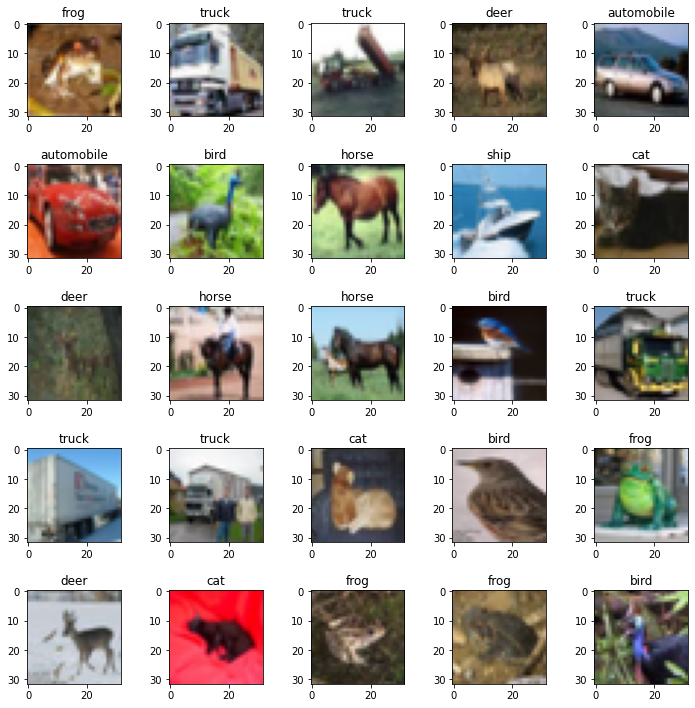

In [3]:
import matplotlib.pyplot as plt

labels = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
n = 5
fig, ax = plt.subplots(n, n, figsize=(10, 10))
fig.tight_layout()
for i, col in enumerate(ax):
    for j, row in enumerate(col):
        row.imshow(x_train[i * n + j])
        row.set_title(labels[y_train[i * n + j].argmax()])

# Define callbacks

In [4]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.callbacks import Callback
import neptune
import os
import time
from PIL import Image


# Define callbacks and monitor
class NeptuneMonitor(Callback):
    def __init__(self, *, test_set=None, send_images=False):
        Callback.__init__(self)
        self.start_time = time.time()
        self.test_set = test_set
        self.send_images = send_images
        if send_images:
            for i, img in enumerate(test_set):
                img = (img * 255).astype('uint8')
                neptune.send_image(f"image_{i}", img)
            

    def on_epoch_end(self, epoch, logs={}):
        for k, v in logs.items():
            neptune.send_metric(k, epoch, v)
        neptune.send_metric('time_elapsed', epoch, time.time() - self.start_time)

        if self.send_images:
            imgs = self.model.predict(self.test_set)
            imgs = imgs.reshape(len(imgs), img_shape[0], img_shape[1], img_shape[2]) * 255
            imgs = imgs.astype('uint8')

            for i, img in enumerate(imgs):
                neptune.send_image(f"image_{i}", img)


reduceLR = ReduceLROnPlateau(factor=0.5, patience=3, verbose=1)
earlyStop = EarlyStopping(restore_best_weights=True, verbose=1, patience=10)

# Define model

In [9]:
def create_model(params):
    dr = params["dropout_rate"]
    kernel_size = params["kernel_size"]

    # Model definition
    model = Sequential([
        Conv2D(64, kernel_size, padding="same", input_shape=img_shape),
        LeakyReLU(0.3),
        Dropout(dr),

        Conv2D(64, kernel_size, padding="same"),
        LeakyReLU(0.3),
        Dropout(dr),
        
        MaxPool2D(),

        Conv2D(128, kernel_size, padding="same"),
        LeakyReLU(0.3),
        Dropout(dr),

        Conv2D(128, kernel_size, padding="same"),
        LeakyReLU(0.3),
        Dropout(dr),
        
        MaxPool2D(),

        Conv2D(256, kernel_size, padding="same"),
        LeakyReLU(0.3),
        Dropout(dr),
        
        Conv2D(256, kernel_size, padding="same"),
        LeakyReLU(0.3),
        Dropout(dr),

        MaxPool2D(),

        Conv2D(512, kernel_size, padding="same"),
        LeakyReLU(0.3),
        Dropout(dr),

        MaxPool2D(),

        Flatten(),
        Dense(1024),
        LeakyReLU(0.3),
        Dropout(dr),

        Dense(10, activation="sigmoid"),
    ])

    model.compile(loss='binary_crossentropy', 
                optimizer=Adadelta(learning_rate=params['lr_start']),
                metrics=['categorical_accuracy'])
    
    return model

In [12]:
# Params
params = {
    'lr_start': 0.1,
    'batch_size': 32,
    'dropout_rate': 0.25,
    'kernel_size': (3, 3),
}

model = create_model(params)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 32, 32, 64)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 16, 16, 64)       

# Run it!

In [13]:
# Run that s***!
with neptune.create_experiment(name="cifar10 classification", params=params):
    neptune.send_metric('params', 0, model.count_params())

    model.fit(x_train, 
            y_train, 
            batch_size=params["batch_size"],
            epochs=1000,
            validation_split=0.1,
            shuffle=True,
            callbacks=[NeptuneMonitor(), reduceLR, earlyStop])
    
    acc = model.evaluate(x_test, y_test)[1]
    neptune.send_metric('test_cat_acc', 0, acc)


https://ui.neptune.ai/miki.pacman/images/e/IM-88
Epoch 1/1000
1407/1407 [==============================] - 32s 22ms/step - loss: 0.3031 - categorical_accuracy: 0.2303 - val_loss: 0.3756 - val_categorical_accuracy: 0.3196
Epoch 2/1000
1407/1407 [==============================] - 31s 22ms/step - loss: 0.2611 - categorical_accuracy: 0.3681 - val_loss: 0.3204 - val_categorical_accuracy: 0.3790
Epoch 3/1000
1407/1407 [==============================] - 31s 22ms/step - loss: 0.2411 - categorical_accuracy: 0.4254 - val_loss: 0.2997 - val_categorical_accuracy: 0.3402
Epoch 4/1000
1407/1407 [==============================] - 31s 22ms/step - loss: 0.2237 - categorical_accuracy: 0.4793 - val_loss: 0.2577 - val_categorical_accuracy: 0.5100
Epoch 5/1000
1407/1407 [==============================] - 31s 22ms/step - loss: 0.2080 - categorical_accuracy: 0.5278 - val_loss: 0.2380 - val_categorical_accuracy: 0.5192
Epoch 6/1000
1407/1407 [==============================] - 31s 22ms/step - loss: 0.1945 - ca

# Final accuracy
It is not a state of the art result, but after multiple tries of different number of layers, kernel sizes and other hyperparameters I think it is highly non trivial to achieve significantly better result by using pure CNNs. I think that the limitng factor may be number of layers (not it's 8 and it's difficuly to optimize models with more layers) as we use standard CNNs and not Residual Nets. Nets with big number of layers tend to be difficult to optimize and I think it makes no sense to try to find an optimal set of parameters/layers for standard CNN when I can just try residual layers

In [15]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.1000 - categorical_accuracy: 0.8115


[0.10004416853189468, 0.8115000128746033]

# Some insights into model
Learning curves can be seen here https://ui.neptune.ai/miki.pacman/images/e/IM-88

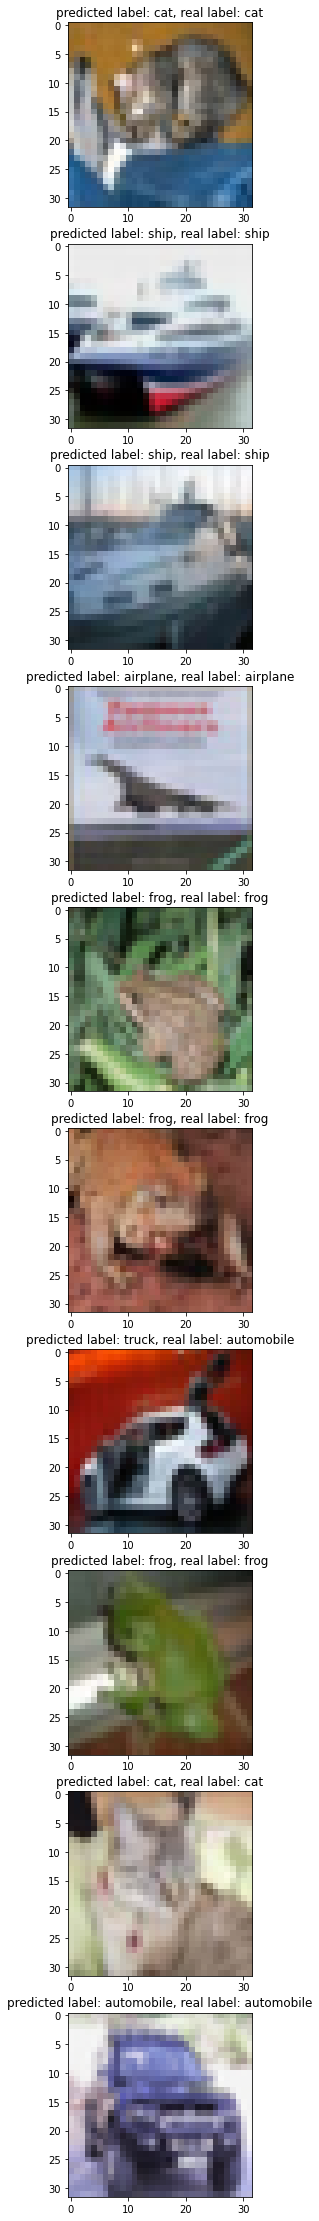

In [20]:
import matplotlib.pyplot as plt

n = 10
fig, ax = plt.subplots(n, figsize=(10, 40))
for im, label, i in zip(x_test[:n], y_test[:n], range(n)):
    ax[i].imshow(im)
    pred = np.argmax(model.predict(im.reshape(1, 32, 32, 3))[0])
    real = np.argmax(label)
    ax[i].set_title(f"predicted label: {labels[pred]}, real label: {labels[real]}")

Confusion Matrix


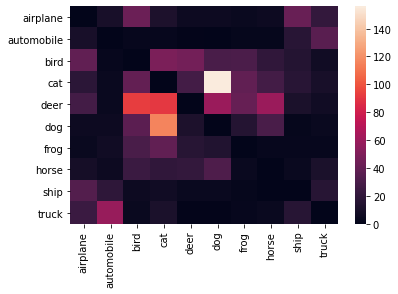

Classification Report
              precision    recall  f1-score   support

    airplane       0.83      0.85      0.84       976
  automobile       0.88      0.92      0.90       958
        bird       0.72      0.75      0.74       961
         cat       0.65      0.66      0.65       992
        deer       0.87      0.69      0.77      1261
         dog       0.70      0.76      0.73       924
        frog       0.86      0.88      0.87       978
       horse       0.85      0.87      0.86       978
        ship       0.87      0.91      0.89       964
       truck       0.89      0.88      0.88      1008

    accuracy                           0.81     10000
   macro avg       0.81      0.82      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns

pred = np.argmax(model.predict(x_test), axis=1) 
real = np.argmax(y_test, axis=1)

cm = confusion_matrix(pred, real)
df = pd.DataFrame(cm, columns=labels, index=labels)
# ignore diagonal
for l in labels:
    df.loc[l, l] = 0

print('Confusion Matrix')
sns.heatmap(df)
plt.show()

print('Classification Report')
print(classification_report(pred, real, target_names=labels))